In [187]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [188]:
def resize_image(img, new_size=(256, 256)):
    return cv.resize(img, new_size)

In [189]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = [] 
    path = []
    data_distribution = {}
    for label in (os.listdir(folder)):
        images = os.listdir(folder+label)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(label)
        count = 0
        for filename in tqdm(os.listdir(folder+label)):
            if count == 100:
                break
            else :
                count += 1
            img = cv.imread(os.path.join(folder+label,filename))
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img, (256, 256))
                filenames.append(filename)
                path.append(label)
                data.append(img)
    return data, filenames, datalabel, path , data_distribution

In [190]:
images, filenames, labels, path, distribusi = insertGambar("dataset/dataset/")

print("Jumlah gambar:", len(images))
print("Jumlah label unik:", len(labels))
print("Jumlah nama file:", len(filenames))
print("Distribusi data:", distribusi)


Acne vulgaris


100%|██████████| 100/100 [00:02<00:00, 46.88it/s]


Rosacea


100%|██████████| 100/100 [00:02<00:00, 46.36it/s]

Jumlah gambar: 200
Jumlah label unik: 2
Jumlah nama file: 200
Distribusi data: {'Acne vulgaris': 100, 'Rosacea': 100}


In [191]:
def display_sample(images):
  plt.figure(figsize=(20,10))
  for i in range(7):
    plt.subplot(1,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap='gray')
  plt.show()    

In [192]:
def equalize_histogram(img):
    return cv.equalizeHist(img)

In [193]:
def gray_scaling(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return gray

In [194]:
def median_filtering(img):
    pad = 1
    padded_img = np.pad(img, pad, mode='edge')
    result = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            window = padded_img[i:i+3, j:j+3].flatten()
            result[i, j] = np.median(window)
    return result

In [195]:
def sobel(image):
    sobel_x = np.array([[1, 0, -1], 
                        [2, 0, -2], 
                        [1, 0, -1]])
    sobel_y = np.array([[1, 2, 1], 
                        [0, 0, 0], 
                        [-1, -2, -1]])
    
    padded_img = np.pad(image, pad_width=1, mode='constant', constant_values=0)
    sobel_result = np.zeros_like(image, dtype=np.uint8)
    
    for i in range(1, padded_img.shape[0] - 1):
        for j in range(1, padded_img.shape[1] - 1):
            region = padded_img[i-1:i+2, j-1:j+2]

            gx = np.sum(region * sobel_x)
            gy = np.sum(region * sobel_y)

            sobel_result[i-1, j-1] = np.sqrt(gx**2 + gy**2)
    sobel_result = (sobel_result / np.max(sobel_result) * 255).astype(np.uint8)
    
    return sobel_result

In [196]:
def erosi(citra, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(citra, pad, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.min(region[kernel == 1])
    return result

def dilasi(citra, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(citra, pad, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.max(region[kernel == 1])
    return result

def opening(citra):
    kernel = np.ones((3, 3), dtype=np.uint8)
    citra_erosi = erosi(citra, kernel)
    citra_opening = dilasi(citra_erosi, kernel)
    return citra_opening


In [197]:
def normalize(image, skala_min=0, skala_max=255):
    image = image.astype(np.float32)
    min_val, max_val = np.min(image), np.max(image)

    if max_val == min_val:
        return np.full(image.shape, skala_min, dtype=np.uint8)  

    return ((image - min_val) * (skala_max - skala_min) / (max_val - min_val) + skala_min).astype(np.uint8)

In [198]:
import numpy as np

def manual_clahe(gray_img: np.ndarray, clip_limit: float = 2.0, tile_grid_size: tuple = (8, 8)) -> np.ndarray:
    h, w = gray_img.shape
    n_tiles_x, n_tiles_y = tile_grid_size
    tile_h = h // n_tiles_y
    tile_w = w // n_tiles_x
    bins = 256
    
    # Hitung clip limit aktual dalam jumlah pixel
    tile_size = tile_h * tile_w
    clip_limit_pixel = int((clip_limit * tile_size) / bins)
    
    # Buat hasil yang akan diisi
    result = np.zeros_like(gray_img, dtype=np.uint8)
    
    # Simpan semua mapping untuk setiap tile
    maps = np.zeros((n_tiles_y, n_tiles_x, bins), dtype=np.uint8)

    # Hitung histogram & mapping untuk tiap tile
    for i in range(n_tiles_y):
        for j in range(n_tiles_x):
            y0, y1 = i * tile_h, (i + 1) * tile_h
            x0, x1 = j * tile_w, (j + 1) * tile_w
            tile = gray_img[y0:y1, x0:x1]
            
            hist, _ = np.histogram(tile, bins=bins, range=(0, 256))
            
            # Clipping
            excess = np.maximum(hist - clip_limit_pixel, 0)
            clipped_hist = hist.copy()
            clipped_hist[clipped_hist > clip_limit_pixel] = clip_limit_pixel
            redistribute = np.sum(excess) // bins
            clipped_hist += redistribute
            
            # Hitung CDF
            cdf = np.cumsum(clipped_hist)
            cdf_min = cdf.min()
            cdf_range = cdf.max() - cdf_min
            if cdf_range == 0:
                cdf_range = 1
            mapping = ((cdf - cdf_min) * 255 / cdf_range).astype(np.uint8)
            maps[i, j] = mapping
    
    # Interpolasi antar tile
    for i in range(h):
        for j in range(w):
            # Posisi relatif di grid tile
            y_frac = (i + 0.5) / tile_h - 0.5
            x_frac = (j + 0.5) / tile_w - 0.5

            y = int(np.floor(y_frac))
            x = int(np.floor(x_frac))

            y = max(0, min(y, n_tiles_y - 2))
            x = max(0, min(x, n_tiles_x - 2))

            dy = y_frac - y
            dx = x_frac - x

            val = gray_img[i, j]

            # Ambil 4 tetangga mapping
            m00 = maps[y, x, val]
            m01 = maps[y, x + 1, val]
            m10 = maps[y + 1, x, val]
            m11 = maps[y + 1, x + 1, val]

            # Bilinear interpolation
            top = (1 - dx) * m00 + dx * m01
            bottom = (1 - dx) * m10 + dx * m11
            interpolated_val = (1 - dy) * top + dy * bottom
            result[i, j] = np.clip(int(round(interpolated_val)), 0, 255)


    return result


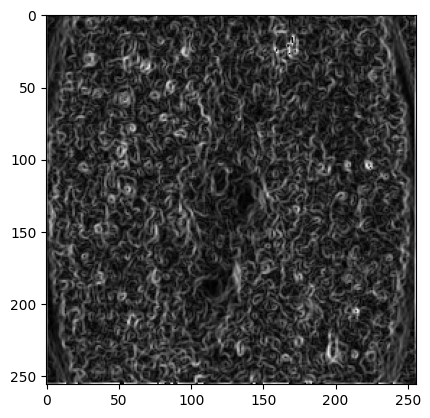

In [199]:
resize_img = resize_image(images[1])  
gray_img = gray_scaling(resize_img)  

citra_clahe = manual_clahe(gray_img, 5, (4,4))

medianData = median_filtering(citra_clahe)  
citra_sobel = sobel(medianData)  

normalizeData = normalize(citra_sobel)  

plt.imshow(normalizeData, cmap="gray")


In [200]:
dataPreprocessed = []
for i in range(len(images)):  
    resize_img = resize_image(images[i])  
    gray_img = gray_scaling(resize_img)  
    
    citra_clahe = manual_clahe(gray_img, 5, (4, 4))
    
    medianData = median_filtering(citra_clahe)  
    citra_sobel = sobel(medianData)  
    
    normalizeData = normalize(citra_sobel)  

    dataPreprocessed.append(normalizeData)

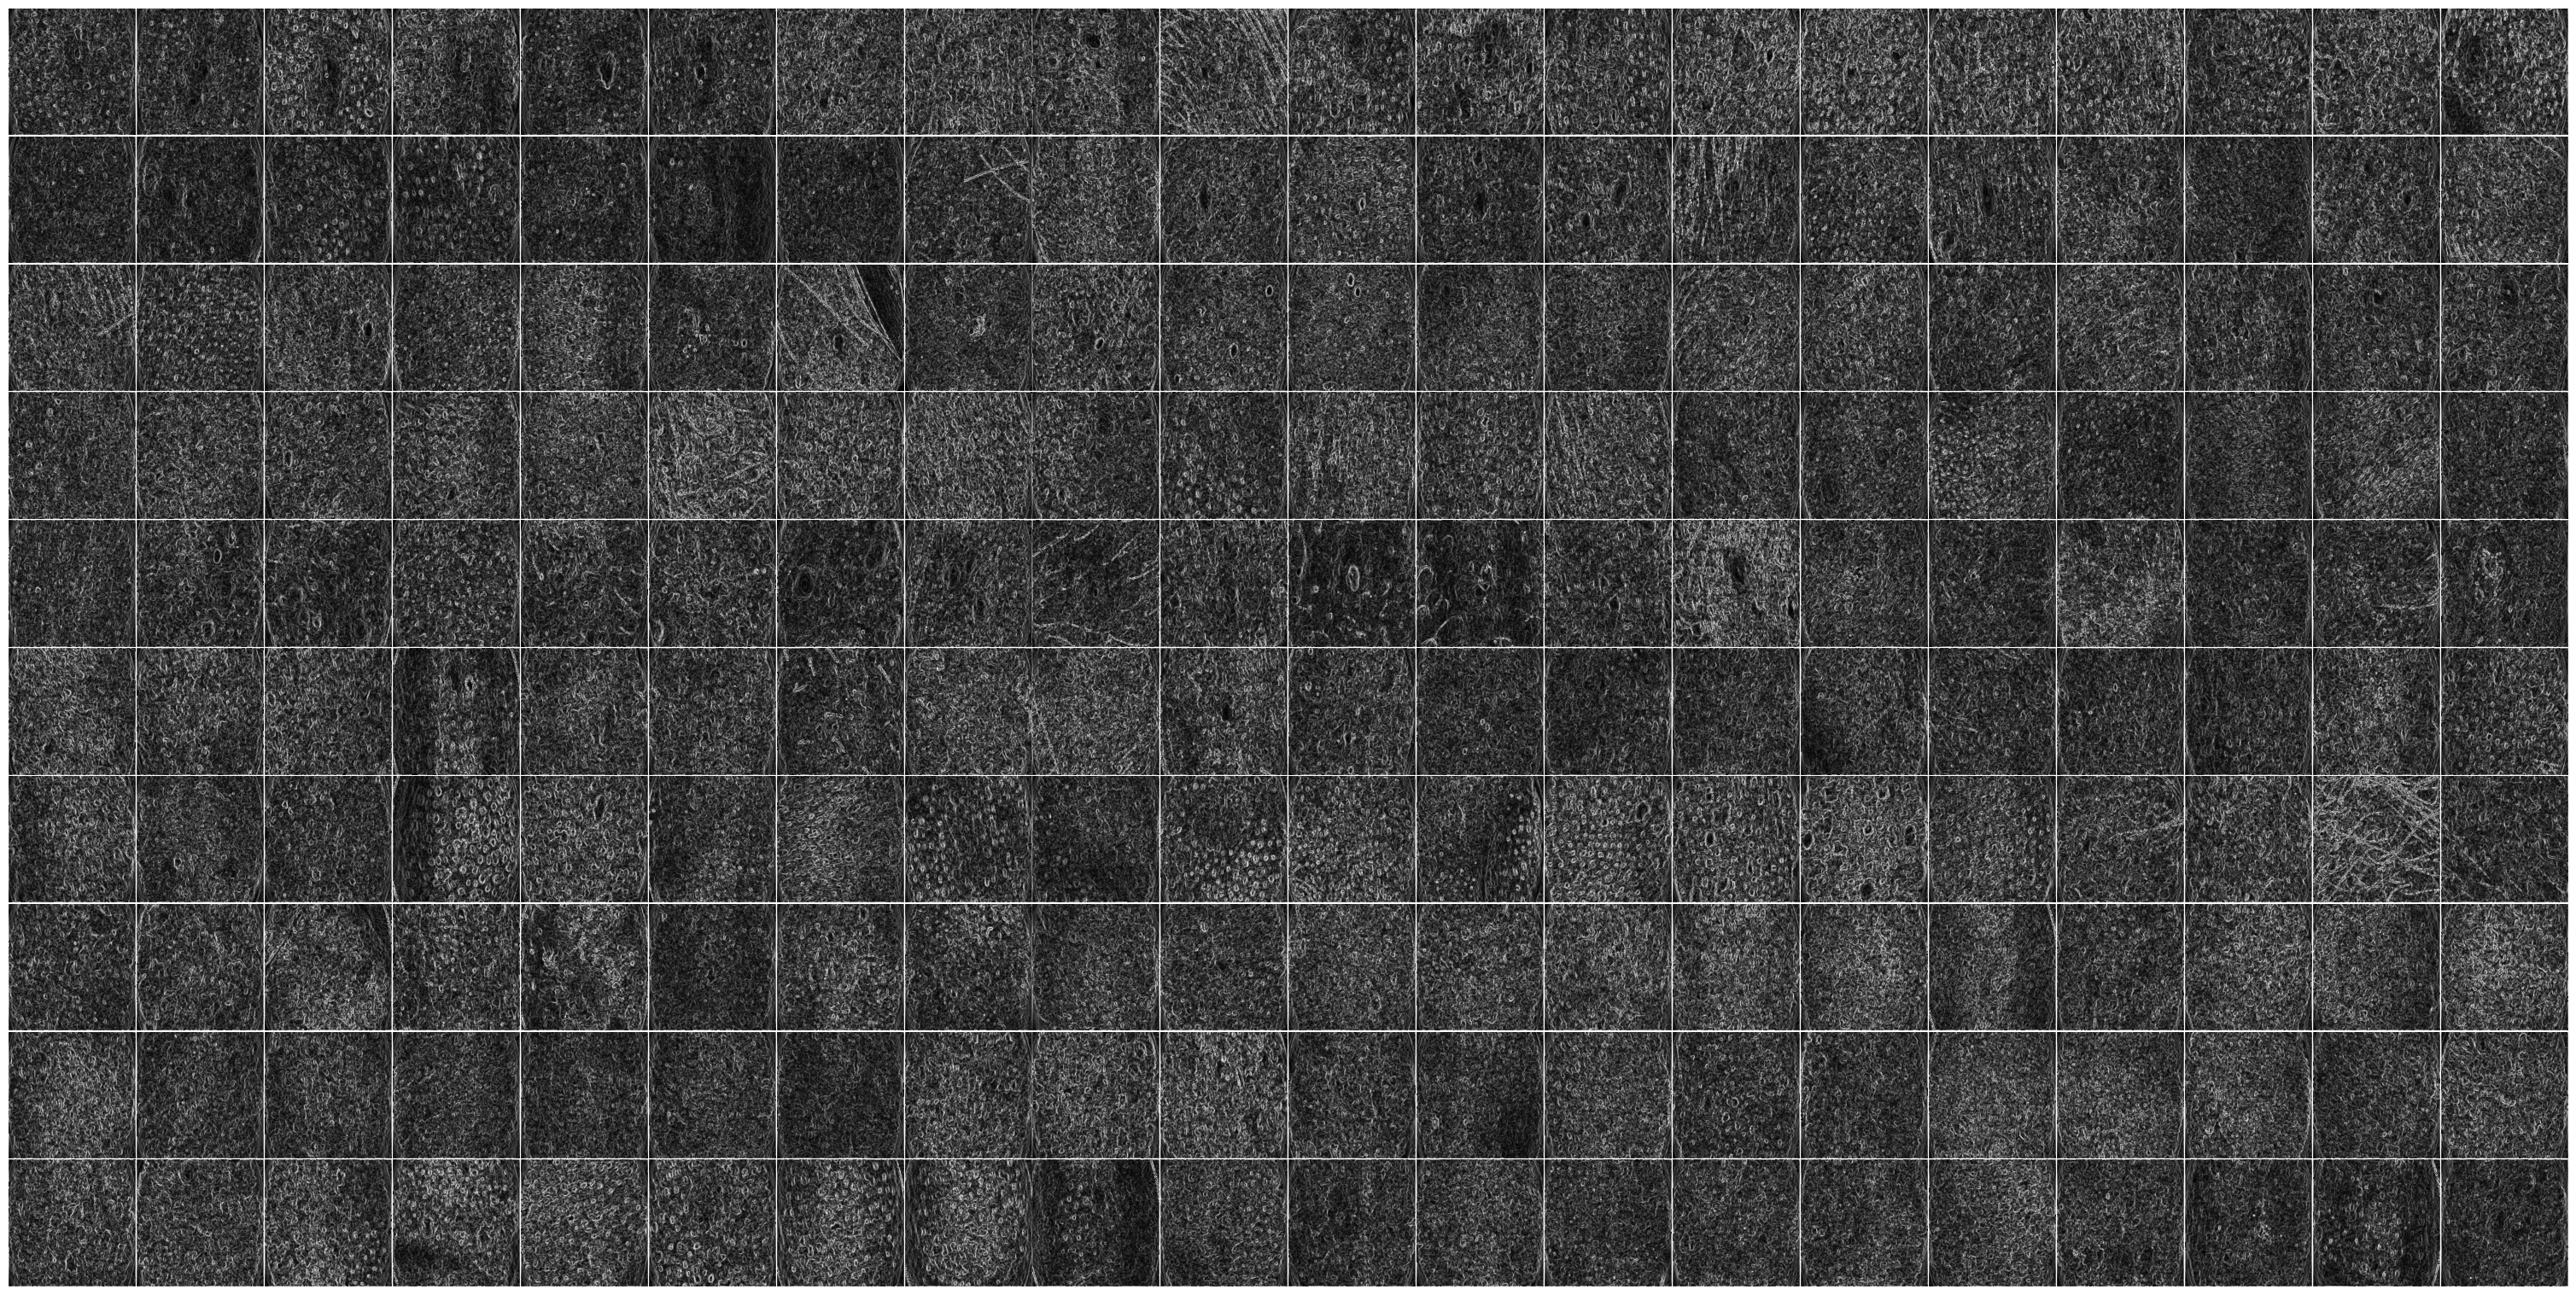

In [201]:
num_images = min(len(images), 200)  

cols = 20  
rows = (num_images // cols) + (1 if num_images % cols else 0)  

fig, axes = plt.subplots(rows, cols, figsize=(30, 15))

for i, ax in enumerate(axes.flat):
    
    if i < num_images:
        img = resize_image(dataPreprocessed[i])  
        ax.imshow(img, cmap='gray')
        ax.axis("off")
    else:
        ax.axis("off")  

plt.tight_layout(pad=0.1)  
plt.show()

<h1>Feature Extraction</h1>

In [202]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [203]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [204]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [205]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [206]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [207]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [208]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [209]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [210]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [211]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [212]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    homogenity0.append(H0)
    H45 = homogenity(Derajat45[i])
    homogenity45.append(H45)
    H90 = homogenity(Derajat90[i])
    homogenity90.append(H90)
    H135 = homogenity(Derajat135[i])
    homogenity135.append(H135)

In [213]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [214]:
for i in range(len(images)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [215]:
for i in range(len(images)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [216]:
for i in range(len(images)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [217]:
for i in range(len(images)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [218]:
for i in range(len(images)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [219]:
print("Jumlah Labels:", len(path))
print("Jumlah Filename:", len(filenames))
print("Jumlah Kontras0:", len(Kontras0), len(Kontras45), len(Kontras90), len(Kontras135))
print("Jumlah Homogeneity0:", len(homogenity0), len(homogenity45), len(homogenity90), len(homogenity135))
print("Jumlah Dissimilarity0:", len(dissimilarity0), len(dissimilarity45), len(dissimilarity90), len(dissimilarity135))
print("Jumlah Entropy0:", len(entropy0), len(entropy45), len(entropy90), len(entropy135))
print("Jumlah ASM0:", len(ASM0), len(ASM45), len(ASM90), len(ASM135))
print("Jumlah Energy0:", len(energy0), len(energy45), len(energy90), len(energy135))
print("Jumlah Correlation0:", len(correlation0), len(correlation45), len(correlation90), len(correlation135))

Jumlah Labels: 200
Jumlah Filename: 200
Jumlah Kontras0: 200 200 200 200
Jumlah Homogeneity0: 200 200 200 200
Jumlah Dissimilarity0: 200 200 200 200
Jumlah Entropy0: 200 200 200 200
Jumlah ASM0: 200 200 200 200
Jumlah Energy0: 200 200 200 200
Jumlah Correlation0: 200 200 200 200


In [220]:
print(df.describe())  # Lihat ringkasan statistik fitur

         Contrast0   Contrast45   Contrast90  Contrast135  Homogeneity0  \
count   200.000000   200.000000   200.000000   200.000000    200.000000   
mean   1171.833548  1833.239871  1142.484375  1832.538735      0.512128   
std     119.453817   186.361859   115.364001   184.955654      0.001903   
min     912.158640  1431.115986   886.776134  1440.486044      0.507488   
25%    1086.714120  1703.793822  1062.616816  1702.487328      0.510720   
50%    1181.339040  1850.442138  1153.032751  1856.305283      0.512226   
75%    1260.100862  1960.630188  1216.037734  1954.673506      0.513426   
max    1488.164047  2346.990942  1465.597733  2333.928689      0.517112   

       Homogeneity45  Homogeneity90  Homogeneity135  Dissimilarity0  \
count     200.000000     200.000000      200.000000      200.000000   
mean        0.297907       0.509333        0.297968       18.543655   
std         0.002269       0.002120        0.002227        0.964415   
min         0.291024       0.503573     

<h1>CSV</h1>

In [221]:
dataTable = {'Filename': filenames, 'Label': path,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

Filename          Label    Contrast0   Contrast45   Contrast90  \
0    10_1.jpg  Acne vulgaris  1089.971829  1478.927812   791.816590   
1    10_2.jpg  Acne vulgaris   938.354948  1307.722122   636.331189   
2    10_3.jpg  Acne vulgaris  1593.496906  1975.071250   877.211887   
3    10_4.jpg  Acne vulgaris  1220.929366  1667.481415   794.330591   
4    10_5.jpg  Acne vulgaris   817.304442  1150.573533   602.222227   
..        ...            ...          ...          ...          ...   
195   9_3.jpg        Rosacea  1353.571032  1955.836217  1135.334835   
196   9_4.jpg        Rosacea  1170.302298  1550.117770   776.668275   
197   9_5.jpg        Rosacea  1038.599066  1339.904960   569.963450   
198   9_6.jpg        Rosacea  1041.968398  1335.326997   599.487883   
199   9_7.jpg        Rosacea   948.662776  1273.892657   579.989782   

     Contrast135  Homogeneity0  Homogeneity45  Homogeneity90  Homogeneity135  \
0    1516.244014      0.051903       0.041859       0.060922        0.042101   
1    1249.305713      0.054786       0.044798       0.068288        0.046514   
2    2003.998785      0.045002       0.038062       0.059662        0.037961   
3    1593.796294      0.050473       0.041430       0.062442        0.041853   
4    1118.070681      0.057876       0.047468       0.070286        0.047365   
..           ...           ...            ...            ...             ...   
195  1903.629143      0.044299       0.034943       0.051257        0.035872   
196  1524.479416      0.048349       0.040558       0.060055        0.040696   
197  1285.726182      0.054563       0.046199       0.072490        0.046218   
198  1283.758016      0.058086       0.049321       0.073548        0.048860   
199  1199.602722      0.056342       0.045931       0.069108        0.047515   

     ...     ASM90    ASM135   Energy0  Energy45  Energy90  Energy135  \
0    ...  0.000144  0.000116  0.011426  0.010765  0.011992   0.010748   
1    ...  0.000168  0.000133  0.012145  0.011452  0.012962   0.011540   
2    ...  0.000122  0.000090  0.010007  0.009493  0.011028   0.009471   
3    ...  0.000139  0.000104  0.010817  0.010167  0.011770   0.010217   
4    ...  0.000181  0.000144  0.012788  0.012002  0.013470   0.012011   
..   ...       ...       ...       ...       ...       ...        ...   
195  ...  0.000103  0.000084  0.009787  0.009148  0.010135   0.009173   
196  ...  0.000142  0.000112  0.011138  0.010543  0.011909   0.010575   
197  ...  0.000186  0.000141  0.012452  0.011820  0.013621   0.011883   
198  ...  0.000207  0.000156  0.013096  0.012399  0.014377   0.012480   
199  ...  0.000187  0.000149  0.012794  0.012069  0.013685   0.012216   

     Correlation0  Correlation45  Correlation90  Correlation135  
0        0.584892       0.420931       0.703072        0.406407  
1        0.581574       0.392868       0.717056        0.420023  
2        0.583057       0.475378       0.770919        0.467748  
3        0.613791       0.459841       0.747620        0.483705  
4        0.620287       0.447282       0.722016        0.463021  
..            ...            ...            ...             ...  
195      0.600641       0.412356       0.665147        0.428065  
196      0.548434       0.384858       0.702926        0.395069  
197      0.517449       0.357468       0.743385        0.383451  
198      0.586508       0.453520       0.762399        0.474575  
199      0.532491       0.342754       0.722046        0.380928  

[200 rows x 30 columns]

<Axes: >

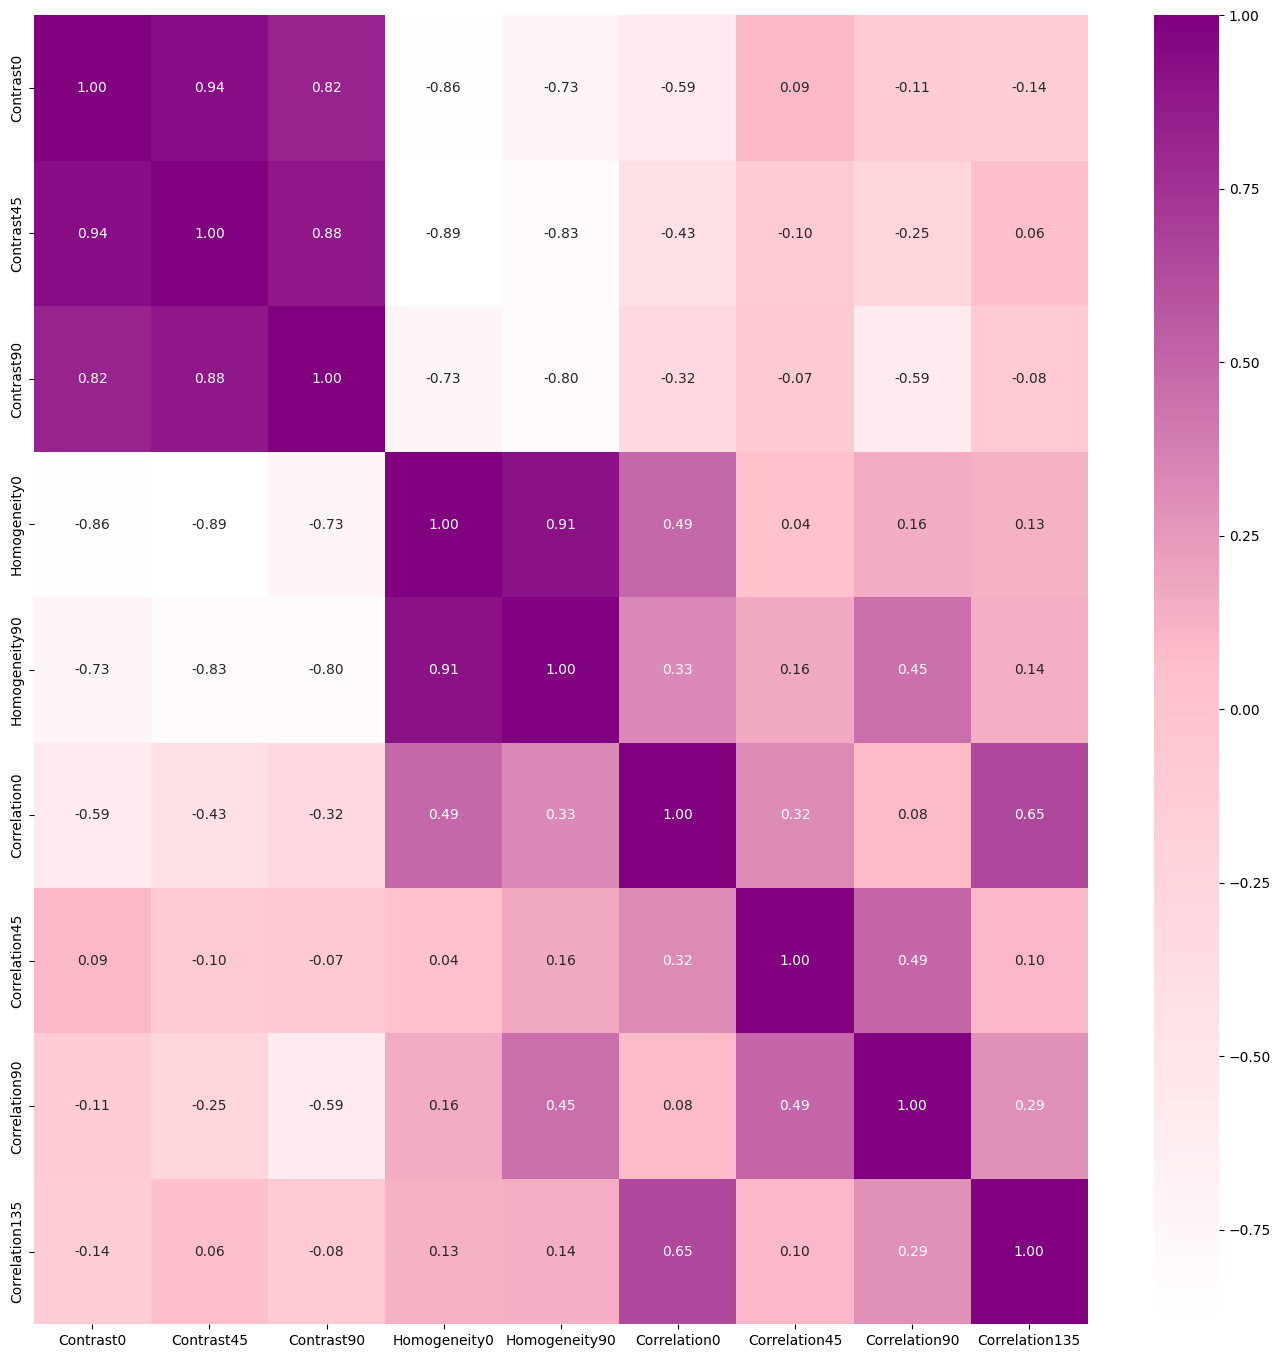

In [222]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))

pink_cmap = LinearSegmentedColormap.from_list("pink_shade", ["white", "pink", "purple"], N=256)
sns.heatmap(x_new.corr(), annot=True, cmap=pink_cmap, fmt=".2f")

In [223]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

(140, 9)
(60, 9)


In [224]:

# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [225]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

In [226]:
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
               precision    recall  f1-score   support

Acne vulgaris       0.97      0.88      0.92        69
      Rosacea       0.90      0.97      0.93        71

     accuracy                           0.93       140
    macro avg       0.93      0.93      0.93       140
 weighted avg       0.93      0.93      0.93       140

[[61  8]
 [ 2 69]]
Accuracy: 0.9285714285714286

------Testing Set------
               precision    recall  f1-score   support

Acne vulgaris       0.72      0.58      0.64        31
      Rosacea       0.63      0.76      0.69        29

     accuracy                           0.67        60
    macro avg       0.67      0.67      0.67        60
 weighted avg       0.68      0.67      0.66        60

[[18 13]
 [ 7 22]]
Accuracy: 0.6666666666666666


In [227]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
               precision    recall  f1-score   support

Acne vulgaris       0.77      0.67      0.71        69
      Rosacea       0.71      0.80      0.75        71

     accuracy                           0.74       140
    macro avg       0.74      0.73      0.73       140
 weighted avg       0.74      0.74      0.73       140

[[46 23]
 [14 57]]
Accuracy: 0.7357142857142858

------Testing Set------
               precision    recall  f1-score   support

Acne vulgaris       0.72      0.68      0.70        31
      Rosacea       0.68      0.72      0.70        29

     accuracy                           0.70        60
    macro avg       0.70      0.70      0.70        60
 weighted avg       0.70      0.70      0.70        60

[[21 10]
 [ 8 21]]
Accuracy: 0.7


In [228]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
               precision    recall  f1-score   support

Acne vulgaris       0.78      0.68      0.73        69
      Rosacea       0.72      0.82      0.77        71

     accuracy                           0.75       140
    macro avg       0.75      0.75      0.75       140
 weighted avg       0.75      0.75      0.75       140

[[47 22]
 [13 58]]
Accuracy: 0.75

------Testing Set------
               precision    recall  f1-score   support

Acne vulgaris       0.59      0.61      0.60        31
      Rosacea       0.57      0.55      0.56        29

     accuracy                           0.58        60
    macro avg       0.58      0.58      0.58        60
 weighted avg       0.58      0.58      0.58        60

[[19 12]
 [13 16]]
Accuracy: 0.5833333333333334


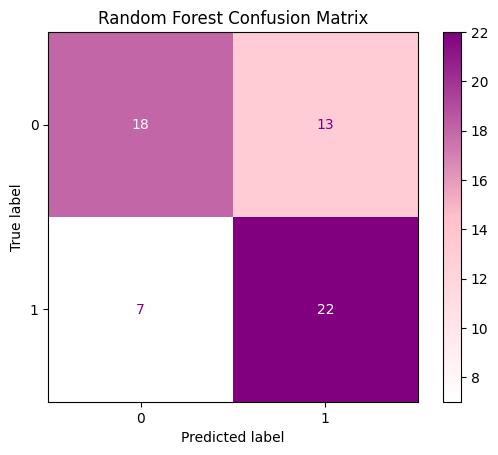

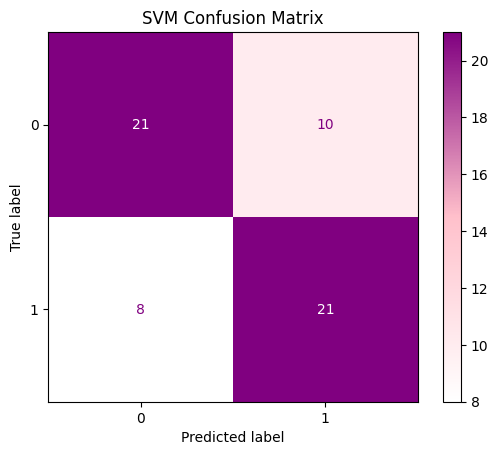

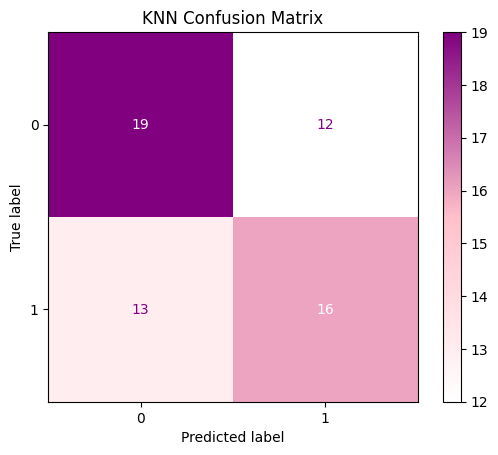

In [229]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=pink_cmap)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")